In [1]:
import os
import pandas as pd
import sqlalchemy
import sklearn
from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv())

connection_string = os.getenv("LINODE_CONN_STRING")
connection_string = os.getenv("LINODE_CONN_STRING")
conn = sqlalchemy.create_engine(os.getenv("LINODE_CONN_STRING")).connect()

In [2]:
data = pd.read_sql("select * from sports_data.tourney_games_v5", conn)

In [3]:
data['Win_Loss_Flag'] = data['Win_Loss'].apply(lambda x: 1 if x == 'W' else 0)

In [4]:
data.columns

Index(['date', 'season', 'team', 'opponent', 'Win_Loss',
       'regular_season_win_pct', 'opponent_regular_season_win_pct',
       'season_win_pct', 'season_ppg', 'opponent_season_ppg',
       'season_ppg_allowed', 'opponent_season_ppg_allowed', 'last_10_win_pct',
       'opponent_last_10_win_pct', 'last_5_win_pct', 'opponent_last_5_win_pct',
       'vs_tourney_team_win_pct', 'opponent_vs_tourney_team_win_pct',
       'games_played_vs_tourney_teams',
       'opponent_games_played_vs_tourney_teams', 'season_adj_offense',
       'opponent_season_adj_offense', 'season_adj_defense',
       'opponent_season_adj_defense', 'vs_tourney_team_adj_offense',
       'opponent_vs_tourney_team_adj_offense', 'vs_tourney_team_adj_defense',
       'opponent_vs_tourney_team_adj_defense', 'season_offensive_efficiency',
       'opponent_season_offensive_efficiency',
       'vs_tourney_team_offensive_efficiency',
       'opponent_vs_tourney_team_offensive_efficiency',
       'season_effective_fg_percent', 

In [5]:
predictor_cols = data.columns.to_list()

In [6]:
predictor_cols.remove('Win_Loss')
predictor_cols.remove('Win_Loss_Flag')
# 'date', 'season', 'team', 'opponent'
predictor_cols.remove('date')
predictor_cols.remove('season')
predictor_cols.remove('team')
predictor_cols.remove('opponent')

In [8]:
predictors = data[predictor_cols]
predictors_and_response = pd.concat([predictors, data['Win_Loss_Flag']], axis=1)

In [9]:
prediction_data = data[predictor_cols]
prediction_data_normalized = (prediction_data-prediction_data.mean())/prediction_data.std()

In [10]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0).fit(prediction_data_normalized, data['Win_Loss_Flag'])

In [11]:
linreg_no_val_predictions = clf.predict(prediction_data_normalized)

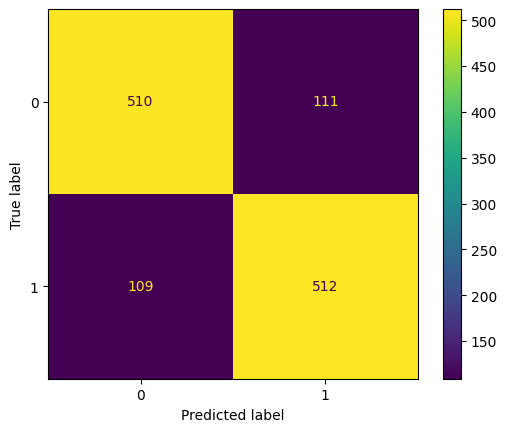

In [12]:
sklearn.metrics.ConfusionMatrixDisplay(sklearn.metrics.confusion_matrix(data['Win_Loss_Flag'], linreg_no_val_predictions)).plot()

In [13]:
def proper_cross_validation(clf, X, y, k=5):
    from sklearn.model_selection import KFold
    kf = KFold(n_splits=k)
    confusion_matrices = []
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        clf.fit(X_train, y_train)
        confusion_matrices.append(sklearn.metrics.confusion_matrix(y_test, clf.predict(X_test)))
    total_confusion_matrix = sum(confusion_matrices)
    return total_confusion_matrix

In [14]:
cms = proper_cross_validation(LogisticRegression(random_state=0), prediction_data_normalized, data['Win_Loss_Flag'])

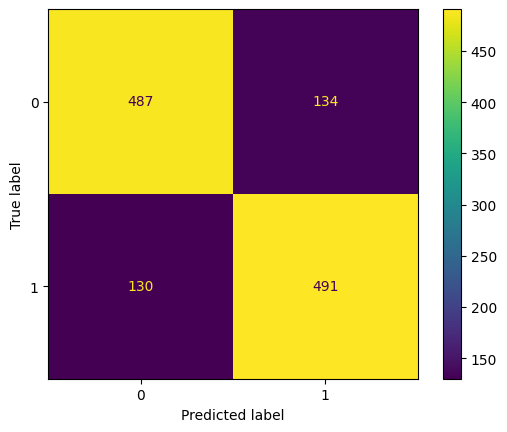

In [15]:
sklearn.metrics.ConfusionMatrixDisplay(cms).plot()

In [16]:
cms

array([[487, 134],
       [130, 491]], dtype=int64)

In [50]:
def expected_games_right(confusion_matrix):
    accuracy = (confusion_matrix[0,0] + confusion_matrix[1,1]) / confusion_matrix.sum()
    print(f"accuracy: {accuracy}")
    gr = 32.0 * accuracy
    gr = gr + (16 * (accuracy ** 2))
    gr = gr + (8 * (accuracy ** 3))
    gr = gr + (4 * (accuracy ** 4))
    gr = gr + (2 * (accuracy ** 5))
    gr = gr + (1 * (accuracy ** 6))
    return gr

In [21]:
def expected_score(confusion_matrix):
    accuracy = (confusion_matrix[0,0] + confusion_matrix[1,1]) / confusion_matrix.sum()
    gr = 32.0 * accuracy
    gr = gr + (32 * (accuracy ** 2))
    gr = gr + (32 * (accuracy ** 3))
    gr = gr + (32 * (accuracy ** 4))
    gr = gr + (32 * (accuracy ** 5))
    gr = gr + (32 * (accuracy ** 6))
    return gr

In [20]:
expected_games_right(cms)

41.40693641972994

In [22]:
expected_score(cms)

90.28439371070144

39.44439260006457
83.01899151935648


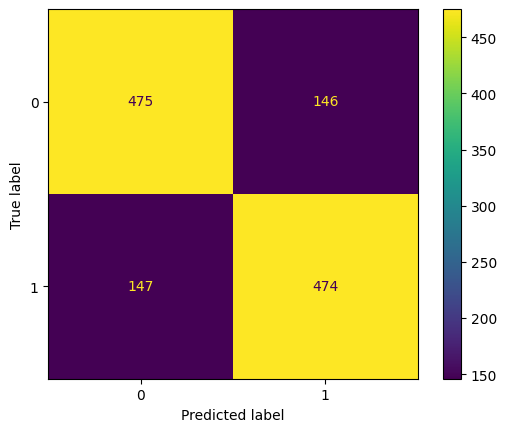

In [25]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(random_state=0, max_iter=3000)
cms = proper_cross_validation(clf, prediction_data_normalized, data['Win_Loss_Flag'])
sklearn.metrics.ConfusionMatrixDisplay(cms).plot()
print(expected_games_right(cms))
print(expected_score(cms))

38.39093177699357
79.2580128017624


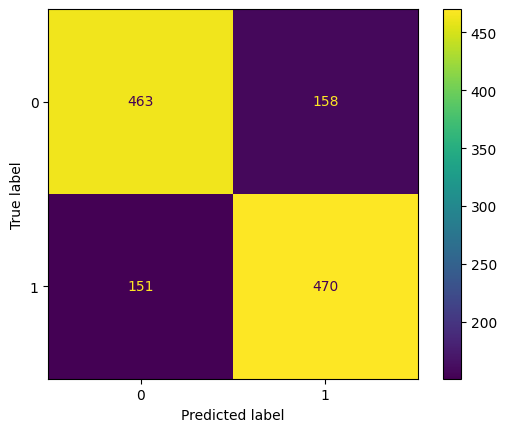

In [27]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(random_state=0, max_iter=3000, hidden_layer_sizes=[100, 100, 100])
cms = proper_cross_validation(clf, prediction_data_normalized, data['Win_Loss_Flag'])
sklearn.metrics.ConfusionMatrixDisplay(cms).plot()
print(expected_games_right(cms))
print(expected_score(cms))

accuracy: 0.7906602254428341
expected games correct: 41.68314821916757
expected score: 91.33398463873138


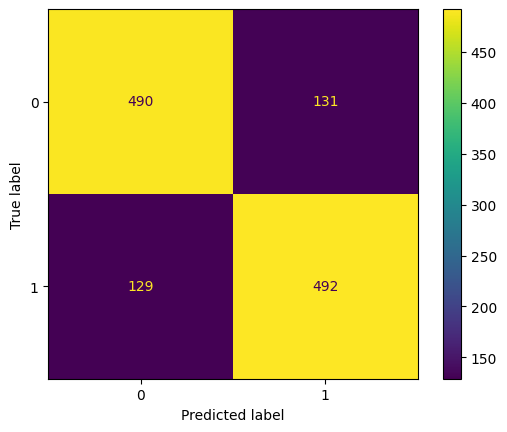

In [52]:
from sklearn.decomposition import PCA
pca = PCA(n_components=56)
pca.fit(prediction_data_normalized)
cms = proper_cross_validation(LogisticRegression(), pd.DataFrame(pca.transform(prediction_data_normalized)), data['Win_Loss_Flag'])
sklearn.metrics.ConfusionMatrixDisplay(cms).plot()
print(f"expected games correct: {expected_games_right(cms)}")
print(f"expected score: {expected_score(cms)}")

accuracy: 0.7326892109500805
expected games correct: 36.91182577679746
expected score: 74.1410865232954


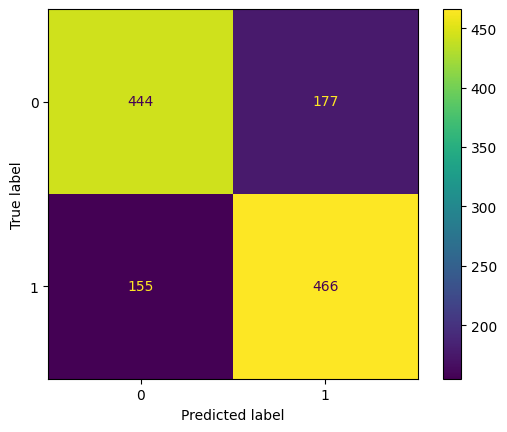

In [64]:
from sklearn.linear_model import SGDClassifier
from sklearn.decomposition import PCA
pca = PCA(n_components=56)
pca.fit(prediction_data_normalized)
cms = proper_cross_validation(SGDClassifier(loss="hinge", penalty="l1", max_iter=2000), pd.DataFrame(pca.transform(prediction_data_normalized)), data['Win_Loss_Flag'])
sklearn.metrics.ConfusionMatrixDisplay(cms).plot()
print(f"expected games correct: {expected_games_right(cms)}")
print(f"expected score: {expected_score(cms)}")

accuracy: 0.7592592592592593
expected games correct: 39.0469461701679
expected score: 81.58866067999828


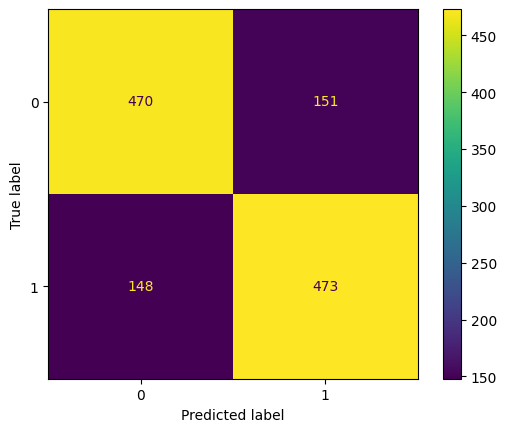

In [65]:
from sklearn import svm
from sklearn.decomposition import PCA
pca = PCA(n_components=56)
pca.fit(prediction_data_normalized)
cms = proper_cross_validation(svm.SVC(), pd.DataFrame(pca.transform(prediction_data_normalized)), data['Win_Loss_Flag'])
sklearn.metrics.ConfusionMatrixDisplay(cms).plot()
print(f"expected games correct: {expected_games_right(cms)}")
print(f"expected score: {expected_score(cms)}")